# Projet sante publique france

## Déjà réalisé

Les données ont été chargée et ont subit un pré-traitement:
   * Les produits ont tous un nom
   * Certains des produits proviennent d'une source fiable est sont donc marqués comme fiables
   * Les données sont désormais dans un fichier `pickle` dans le dossier `data/interim`

## Nettoyage des données 
Les données étant crées par les utilisateurs, les données sont "sales". Il faut retirer toutes les données qui sont des erreurs de saisie.



In [1]:
import os
import re
from pprint import pprint

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import unicodedata
from wordcloud import WordCloud

plt.rcdefaults()
font = {'size'   : 16}

sns.set()
plt.rc('font', **font)

In [2]:
# On récupère les données du premier traitement
data = pd.read_pickle('../data/interim/products_interim.pickle')

In [3]:
trusted_product_count = data[data['trusted_src']]['trusted_src'].count()
total = data.shape[0]
percentage = trusted_product_count / total * 100
print(f'On a donc : {trusted_product_count} produits "trustés" sur : {total} soit : {percentage} %')
del trusted_product_count, total, percentage

On a donc : 1499 produits "trustés" sur : 600654 soit : 0.2495613115037942 %


Quels sont les champs complétés par les utilisateurs ?

En effet, certains champs sont remplis automatiquement, les timestamps, le créateur, l'url ...
On peut donc regarder les taux de remplissage des différents produits. Les produits les moins compléter seront alors retirés.

In [4]:
fields = list(data.columns)
len(fields)

155

nombre minimun et maximum de champs complétés

In [5]:
data['complete'] = data.count(axis=1)
print(f"Nombre de champs minimum {data['complete'].min()}")
print(f"Nombre de champs complétés au maximum {data['complete'].max()}")

Nombre de champs minimum 18
Nombre de champs complétés au maximum 97


In [6]:
data['complete'] = data['complete'] - data['complete'].min()
data['complete'] = data['complete'] / data['complete'].max() * 100

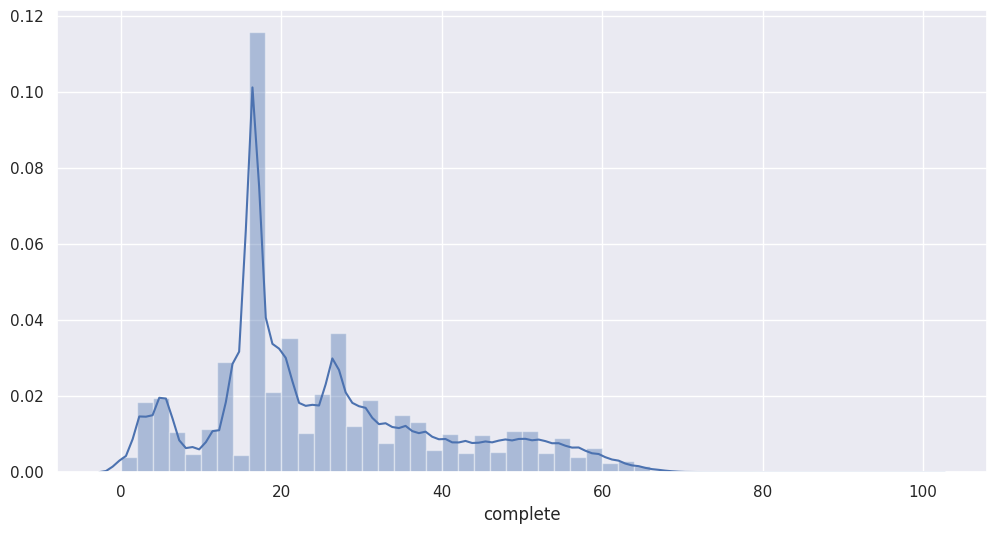

In [7]:
plt.figure(figsize=(12, 6))
sns.distplot(data['complete'])
plt.show()

regardons les champs de plus près

In [8]:
print(data.columns.values)

['code' 'url' 'creator' 'created_datetime' 'last_modified_datetime'
 'product_name' 'generic_name' 'quantity' 'packaging' 'packaging_tags'
 'brands' 'brands_tags' 'categories' 'categories_tags' 'categories_en'
 'origins' 'origins_tags' 'manufacturing_places'
 'manufacturing_places_tags' 'labels' 'labels_tags' 'labels_en'
 'emb_codes' 'emb_codes_tags' 'first_packaging_code_geo' 'cities_tags'
 'purchase_places' 'stores' 'countries' 'countries_tags' 'countries_en'
 'ingredients_text' 'allergens' 'traces' 'traces_tags' 'traces_en'
 'serving_size' 'serving_quantity' 'additives_n' 'additives'
 'additives_tags' 'additives_en' 'ingredients_from_palm_oil_n'
 'ingredients_from_palm_oil_tags'
 'ingredients_that_may_be_from_palm_oil_n'
 'ingredients_that_may_be_from_palm_oil_tags' 'nutrition_grade_fr'
 'nova_group' 'pnns_groups_1' 'pnns_groups_2' 'states' 'states_tags'
 'states_en' 'main_category' 'main_category_en' 'image_url'
 'image_small_url' 'image_ingredients_url' 'image_ingredients_small_ur

### Temps écoulé entre l'ajout et la dernière modification

#### Motivation

La BDD fonctionne comme wikipédia, chaque produit est vérifié par les pairs. 

Hypothèse : Un produit qui a été modifié à plusieurs reprises a plus de chances d'être correctement complété.

In [9]:
data['dt'] = data['last_modified_datetime'] - data['created_datetime']

In [10]:
data.sort_values(by='dt', ascending=False, inplace=True)

In [11]:
data[['product_name', 'complete', 'dt']]

,product_name,complete,dt
578843,Thoïonade aux olives et aux câpres,48.101266,2831 days 15:15:13
578829,Crème de sardine au whisky,45.569620,2822 days 00:20:03
418061,Boudoirs,58.227848,2819 days 01:52:46
535639,Sainte Maure,46.835443,2809 days 15:50:39
728913,Arroz sushi,43.037975,2803 days 04:30:15
...,...,...,...
610891,Miel De L'Yonne 500g,0.000000,0 days 00:00:00
25901,Cheez-it Baked Snack Crackers,13.924051,0 days 00:00:00
1031437,맛있는 즐거움 포도 100,13.924051,0 days 00:00:00
537740,salade,0.000000,0 days 00:00:00


In [12]:
data['dt'].describe()

count                      600654
mean     292 days 12:20:23.969018
std      426 days 16:17:35.345674
min               0 days 00:00:00
25%               0 days 00:00:09
50%       94 days 12:16:22.500000
75%      450 days 04:43:14.250000
max            2831 days 15:15:13
Name: dt, dtype: object

In [13]:
data['dt'] = data['dt'].map(lambda x : x.total_seconds())
data[['complete', 'dt']].corr()

,complete,dt
complete,1.000000,0.560629
dt,0.560629,1.000000


Pas assez corrélés

### Nutrition score

On retire les produits pour lesquels on a pas de nutriscore/nutrigrade (si on a l'un, on a forcément l'autre).

In [14]:
print('Nombre de produits sans "nutrigrade" : %i' % (data[data['nutrition_grade_fr'].isna()].shape[0]))
print('Nombre de produits sans "nutriscore" : %i' % (data[data['nutrition-score-fr_100g'].isna()].shape[0]))
data.drop(data[data['nutrition-score-fr_100g'].isna()].index, axis=0, inplace=True)
print("Nombre de produits restants : %i " % data.shape[0])

Nombre de produits sans "nutrigrade" : 412869
Nombre de produits sans "nutriscore" : 412869
Nombre de produits restants : 187785 


Présence du Nutri-score (ou grade) et pays.

In [15]:
data.loc[~data['nutrition-score-fr_100g'].isna()]['countries_tags'].value_counts() \
/ data[~data['nutrition_grade_fr'].isna()].shape[0] * 100

en:france         95.522539
en:switzerland     2.388902
en:belgium         2.040099
en:luxembourg      0.048460
Name: countries_tags, dtype: float64

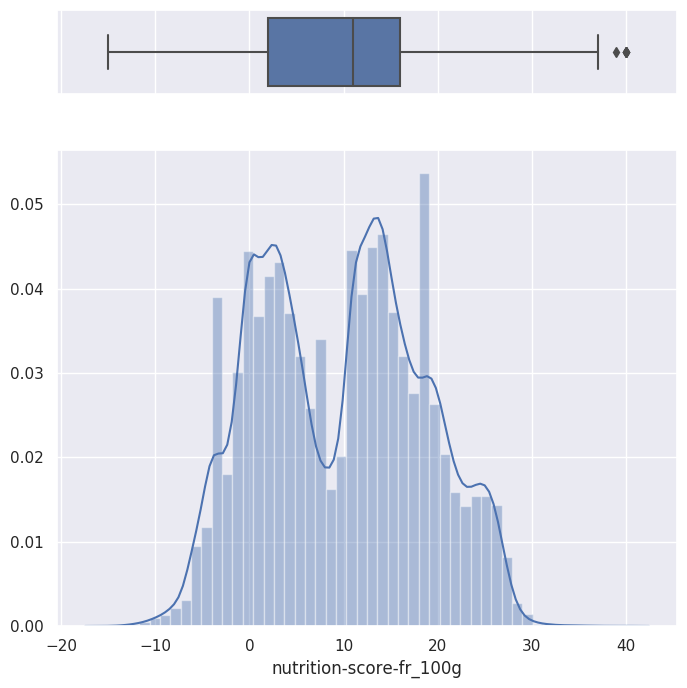

In [16]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(8, 8),
                                    gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(data['nutrition-score-fr_100g'], ax=ax_box)
sns.distplot(data['nutrition-score-fr_100g'], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

In [17]:
cols = ['product_name', 
        'nutrition-score-fr_100g',
        'ingredients_text',
        'brands',
        'nutrition_grade_fr'
       ]
data.sort_values(by='nutrition-score-fr_100g', ascending=False).head()[cols]

,product_name,nutrition-score-fr_100g,ingredients_text,brands,nutrition_grade_fr
697898,whey chocolat,40.0,"Whey protein concentrate (89,5%), Low-fat coco...",Body Attack,e
1037750,Matcha Latte - Green Tea,40.0,NaN,NaN,e
332554,Granulowany napój herbaciany,40.0,Granulowany napéj herbaciany o smaku cytrynowy...,Cynxshno,e
123240,Klik,40.0,NaN,Klik,e
421744,Sprits au beurre,40.0,"Farine de _blé_ (44%), beurre concentré (26 %)...",Belle France,e


Vérifier la correspondance entre le nutriscore et le nutrigrade

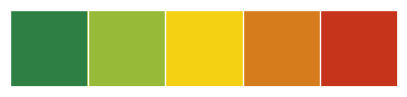

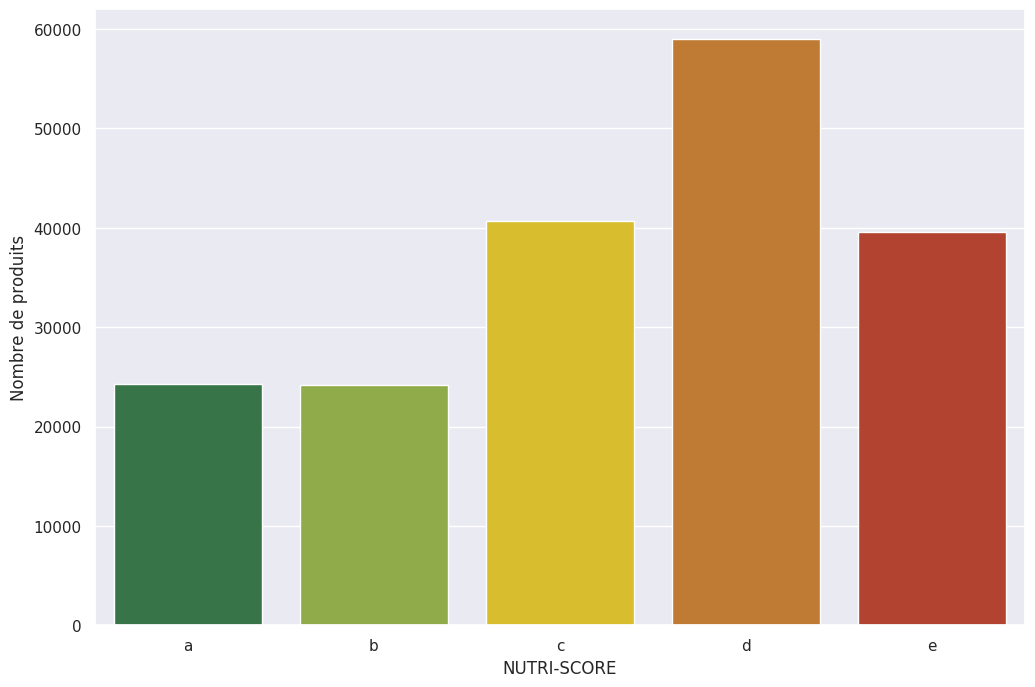

In [18]:
nutorder = ['a','b','c','d','e']
nutscore = ["#2D7F44", "#97BB39", "#F4D113", "#D67C1C", "#C6341B"]
sns.palplot(sns.color_palette(nutscore))
plt.figure(figsize=(12,8))
sns.countplot(x="nutrition_grade_fr", data=data, order=nutorder, palette=nutscore)
plt.xlabel('NUTRI-SCORE')
plt.ylabel('Nombre de produits')
plt.show()

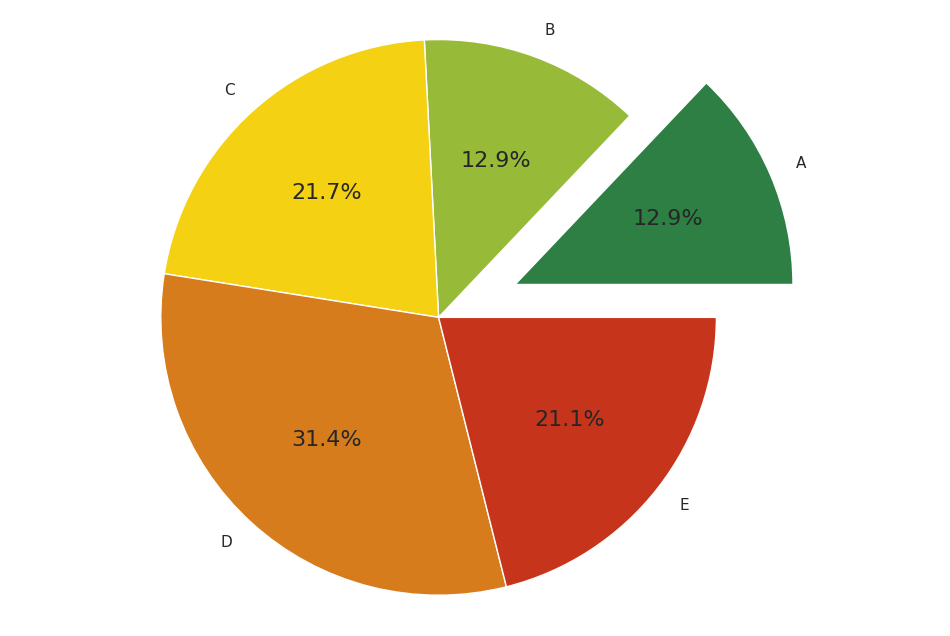

In [19]:
val = data.nutrition_grade_fr.value_counts().sort_index()
plt.figure(figsize=(12,8))
plt.pie(val,
        labels=val.index.str.upper(),
        autopct='%1.1f%%',
        colors=nutscore,
        explode = (0.3, 0, 0, 0, 0));

plt.axis('equal') ;

### Quantité

On commence par supprimer les produits pour lesquels on a pas de quantité

On regarde ensuite si la quantité contient bien une unité (si la case est seulement numérique alors on la drop)

On regarde ensuite si la case n'est pas uniquement du texte 

In [20]:
print('Nombre de produits sans "quantité" : %i' % (data[data['quantity'].isna()].shape[0]))
data.drop(data[data['quantity'].isna()].index, axis=0, inplace=True)

Nombre de produits sans "quantité" : 77872


In [21]:
print('Nombre de quantités sans unité : %i' % (data[data['quantity'].apply(lambda s : s.isnumeric())].shape[0]))
data.drop(data[data['quantity'].apply(lambda s : s.isnumeric())].index, axis=0, inplace=True)

Nombre de quantités sans unité : 1398


In [22]:
print('Nombre de produits dont la quantité est textuelle uniquement: %i' % data[data['quantity'].apply(lambda s : s.isalpha())].shape[0])
data.drop(data[data['quantity'].apply(lambda s : s.isalpha())].index, axis=0, inplace=True)

Nombre de produits dont la quantité est textuelle uniquement: 81


Pour la suite, on va normaliser les chaines de caractères en retirant les accents et autres symboles non latin.

In [23]:
def normalize_string(string):
    """Remove non ascii characters in a string.
    
    :example::
        >>>normalize_string("é")
        'e'
    """
    string = unicodedata.normalize('NFD', string)
    string = string.encode('ascii', 'ignore')
    string = string.decode("utf-8")
    return string

In [24]:
data['quantity'] = data['quantity'].apply(normalize_string)
data['quantity'] = data['quantity'].apply(lambda x : x.replace('= &gt', ''))

Les quantités sont entrées sans format. Par conséquent, les unités peuvent être exprimées de plusieurs façons ex: "grammes", "gramme", "gr" pour "g", on crée donc un dictionnaire avec les différentes correspondances trouvées.

In [25]:
mapper = {"grammes" : "g",
          "gramme" : "g",
          "g e" : "g",
          "gr" : "g",
          "grs" : "g",
          "g egoutte" : "g",
          "g egouttes" : "g",
          "g net" : "g",
          "gr." : "g",
          "gr" : "g",
          "g net egoutte" : "g",
          "g poids net egoutte" : "g",
          "g minimum" : "g",
          "ge" : "g",
          "g poids net" : "g",
          "g total" : "g",
          "g poids net total" : "g",
          "g." : "g",
          "g ." : "g",
          ".gr" : "g",
          "gram" : 'g',
          "gramm" : "g",
          "g net total": "g",
          "g e egoutte" : "g",
          "g env." : "g",
          "grams" : "g",
          "g environ": "g",
          "kg e" : "kg",
          "kg." : "kg",
          "kg environ" : "kg",
          "kg egoutte" : "kg",
          "kgs" : "kg",
          "kilos" : "kg",
          "litres": "l", 
          "litre" : "l",
          "liter" : "l",
          "ls" : "l",
          "l e" : "l",
          "l." : "l",
          "l.e" : "l",
          "lt" : "l",
          "cl e": "cl",
          "cl." : "cl",
          "cl e" : "cl",
          "ml e" : "ml",
          "ml." : "ml",
          "ufs" : "oeufs",
          }

In [26]:
def simple_unit_extractor(string):
    """Extract the quantity as float and the unit as str.
    :args::
        string (str) : the string contening the quantity followed by the unit
    :return::
        tuple (quantity (float), unit_ (str))
    :example::
        >>> simple_unit_extractor('100 g')
        (100.0, 'g')
        
        >>> simple_unit_extractor('2 x 100g')
        (200.0, 'g')
        
        >>> simple_unit_extractor('un gramme')
    """
    string = string.lower().strip()
    frmt = re.compile(r'^(\d+[,\.]?\d*)[\s*]?([a-z\s\.]+)$')
    match_1 = re.match(frmt, string)
    frmt2 = re.compile(r'^(\d+)\s*[x\*]{1}\s*(\d+[\.,]?\d*)([a-z\s\.]+)$')
    match_2 = re.match(frmt2, string)
    if match_1:
        qty = float(match_1.group(1).replace(',', '.'))
        unit = match_1.group(2).strip()
        unit = unit if not mapper.get(unit) else mapper.get(unit)
    elif match_2:
        qty = int(match_2.group(1)) * float(match_2.group(2).replace(',', '.'))
        unit = match_2.group(3).strip()
        unit = unit if not mapper.get(unit) else mapper.get(unit)
    else:
        #print(string)
        return None
    return qty, unit

In [27]:
def complex_unit_extractor(string):
    """Extract the quantity as float and the unit as str.
    :args::
        string (str) : the string contening the quantity folowed by the unit
    :return::
        tuple (quantity (float), unit_ (str))
    :example::
        >>> complex_unit_extractor('100 g')
        (100.0, 'g')
        
        >>> complex_unit_extractor('2 x 100g')
        (200.0, 'g')
        
        >>> complex_unit_extractor('un gramme')
        
        >>> complex_unit_extractor('100 g (2 x 50g)')
        (100.0, 'g')
        
        >>> complex_unit_extractor('6 * 1,5 L')
        (9.0, 'l')
    """
    string = string.lower().strip()
    if simple_unit_extractor(string):
        return simple_unit_extractor(string)
    
    frmt = re.compile(r'^(.+)\s*\((.+)\)$')
    frmt2 = re.compile(r'^(.*),(.*)$')
    
    
    match_1 = re.match(frmt, string)
    match_2 = re.match(frmt2, string)

    
    if match_1 or match_2:
        match = match_1 if match_1 else match_2
        group1 = simple_unit_extractor(match.group(1).strip()) 
        group2 = simple_unit_extractor(match.group(2).strip())
        if group1 and group2:
            if group1 == group2:
                qty, unit = group1
            else:
                #print(f'double check results! we kept {group1} and not {group2}')
                qty, unit = group1
        elif group1 and not group2:
            qty, unit = group1
        elif not group1 and group2:
            qty, unit = group2
        else:
            return None
    
    else:
        print(string)
        return None
    return qty, unit

In [28]:
data['quantity_tuple'] = data['quantity'].apply(complex_unit_extractor)

160 g + 80 g = 240 g
330g + 200g
250 g ou 2 * 125 g
100g de 9 a 11 pieces
720 g [2 x (6 x 60 g)]
1 kg (20 x 50 g) =&gt; 10 portions de 2 croquettes
x 6
20 cl ?
500 g (27 batonnets) ; 10 portions
18
69 g sec pour 2 portions de 350 ml preparees
400 g (egoutte : 265 g) 425 ml
x6
x10
750 g (7/8 personnes) environ 28 tranches
500 g soit (4 x 125 g)e
x6
16 biscuits dans 4 etuis fraicheur
2*100 g - 200 g
non precise
x3 soit 375 g
140 g - 3 a 4 sardines
4 x 18g = 72g
x12
6
2*80 g - 160 g
160 g + 40 g gratuits = 200 g
400g total 220g egoutte
400 ml (4 * 100ml) / 306 g e
x12
450 g - 24 tranches
120 g = 1 pers.
pn : 132 g - pne : 93 g
10 crepes soit 300 g
x20
400 g total pour 280 g egoutte
400 g (10x40 g) ou 500 ml
sachet500 g
270 g pour 9 tartellettes
6
135 g - 95 g egoutte
800g total 440g egoutte
510 g - 450 ml
510 g + 90 g = 600 g
160 g - 112 g egoutte
x125 g
16 biscuits - 4*50 g - 200 g
160 g / 170 ml
16 biscuits - 115 g e
x2
720 g [2 x (6 x 60 g)]
poids net : 560 g egoutte : 340 g
1/4 169 g


In [29]:
print(f"Produits ayant un problème de quantité {data[data['quantity_tuple'].isna()].shape[0]}")
print(f"Soit {data[data['quantity_tuple'].isna()].shape[0] / data.shape[0] * 100} %")
data.drop(data[data['quantity_tuple'].isna()].index, axis=0, inplace=True)

Produits ayant un problème de quantité 2303
Soit 2.123872586089234 %


In [30]:
data['quantity_unit'] = data['quantity_tuple'].apply(lambda x : x[1])

In [31]:
data['quantity_unit'].value_counts().tail(30)

cake                   1
sheets                 1
salades                1
cl  e                  1
gummies                1
etuis fraicheur        1
gros oeufs             1
g apres preparation    1
g de poisson           1
boites                 1
gro                    1
litro                  1
escargots prepares     1
g poids egoutte        1
saucisses              1
rondas                 1
hrs                    1
....kg                 1
buchettes              1
fondants               1
baguettes              1
gros net               1
etuis individuels      1
cc                     1
g egoute               1
tranche de rosette     1
caps                   1
grammed                1
personnes              1
ci                     1
Name: quantity_unit, dtype: int64

In [32]:
data['quantity_unit'].value_counts()

g                     86440
l                      5973
kg                     5377
ml                     3743
cl                     3650
                      ...  
tranche de rosette        1
caps                      1
grammed                   1
personnes                 1
ci                        1
Name: quantity_unit, Length: 244, dtype: int64

In [33]:
suspects = list()
weird_unit = data['quantity_unit'].value_counts()[data['quantity_unit'].value_counts() <= 100]
for elt in weird_unit.index.values:
    suspects.append(data[data['quantity_unit'] == elt])
suspects = pd.concat(suspects)
print(f"Nombre de produits dont l'unité est problématique {suspects.shape[0]}")

Nombre de produits dont l'unité est problématique 683


### Marques

In [34]:
print('Nombre de produits sans "marque" : %i' % (data[data['brands_tags'].isna()].shape[0]))

Nombre de produits sans "marque" : 4097


In [35]:
data.drop(data[data['brands_tags'].isna()].index, axis=0, inplace=True)

In [36]:
data['brands_tags'].value_counts().head()

auchan          3255
carrefour       3089
u               3083
casino          2302
leader-price    1946
Name: brands_tags, dtype: int64

### Catégories

In [51]:
for elt in data.columns:
    if 'categ' in elt:
        print(elt)
        display(data[elt].head())

categories_tags


578843    en:canned-foods,en:meats,en:spreads,en:prepare...
578829    en:meats,en:spreads,en:canned-foods,en:prepare...
418061    en:snacks,en:sweet-snacks,en:biscuits-and-cake...
535639    en:dairies,en:fermented-foods,en:fermented-mil...
728913    en:plant-based-foods-and-beverages,en:plant-ba...
Name: categories_tags, dtype: object

categories_en


578843    Canned foods,Meats,Spreads,Prepared meats,Salt...
578829    Meats,Spreads,Canned foods,Prepared meats,Salt...
418061    Snacks,Sweet snacks,Biscuits and cakes,Biscuit...
535639    Dairies,Fermented foods,Fermented milk product...
728913    Plant-based foods and beverages,Plant-based fo...
Name: categories_en, dtype: object

main_category


578843                       en:canned-foods
578829                              en:meats
418061                             en:snacks
535639                            en:dairies
728913    en:plant-based-foods-and-beverages
Name: main_category, dtype: object

main_category_en


578843                       Canned foods
578829                              Meats
418061                             Snacks
535639                            Dairies
728913    Plant-based foods and beverages
Name: main_category_en, dtype: object

In [52]:
categories = data['main_category_en']

In [53]:
categories.describe()

count                              102010
unique                               2109
top       Plant-based foods and beverages
freq                                24922
Name: main_category_en, dtype: object

In [54]:
categories.value_counts()

Plant-based foods and beverages    24922
Snacks                             17754
Dairies                            10857
Meats                               9390
Meals                               7219
                                   ...  
fr:gibier                              1
fr:protein-mix                         1
fr:toast-nature                        1
fr:2053-kj-pour-100-g                  1
fr:pogne                               1
Name: main_category_en, Length: 2109, dtype: int64

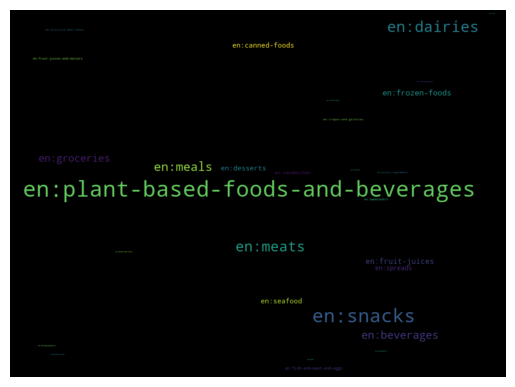

In [41]:
wordcloud = WordCloud(width=1080, height=800, margin=0).generate_from_frequencies(categories.value_counts().to_dict())

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

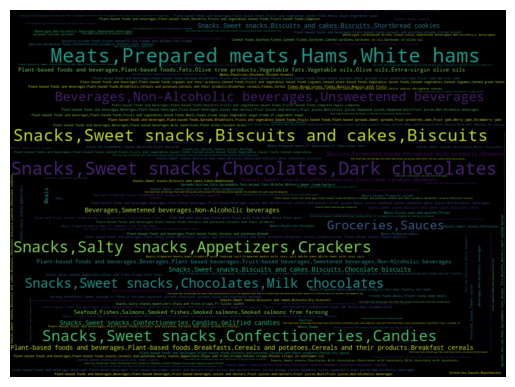

In [42]:
wordcloud = WordCloud(width=1080, height=800, margin=0).generate_from_frequencies(data['categories_en'].value_counts().to_dict())

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

### Valeurs \*_100g

In [43]:
data2 = data[[x for x in data.columns if x.endswith("_100g")]]

In [44]:
data2.describe()

,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-lauric-acid_100g,-arachidic-acid_100g,-cerotic-acid_100g,...,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
count,3.768800e+04,6.685400e+04,1.017640e+05,21.000000,101762.000000,101763.000000,0.0,2.000000,1.0,1.0,...,222.000000,5955.000000,102034.000000,102034.000000,1.0,3.00000,0.0,7.000000,2.000000,1.000
mean,1.026044e+04,1.244030e+03,4.587482e+03,648.485714,14.318568,5.610347,NaN,49.500000,0.0,4.0,...,306.630201,539.333381,8.884764,8.700139,44.0,0.10400,NaN,6.800000,0.022000,0.572
std,1.780575e+06,2.158646e+04,1.083730e+06,585.369810,17.842419,8.417283,NaN,0.707107,NaN,NaN,...,386.115979,761.478929,8.888745,9.328749,NaN,0.03079,NaN,6.746357,0.002828,NaN
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,NaN,49.000000,0.0,4.0,...,0.000000,0.205000,-15.000000,-15.000000,44.0,0.07000,NaN,1.500000,0.020000,0.572
25%,4.560000e+02,4.770000e+02,4.690000e+02,109.000000,1.500000,0.300000,NaN,49.250000,0.0,4.0,...,56.525000,115.440000,1.000000,1.000000,44.0,0.09100,NaN,3.400000,0.021000,0.572
50%,9.810000e+02,1.063000e+03,1.037000e+03,732.000000,7.700000,2.100000,NaN,49.500000,0.0,4.0,...,185.000000,329.360000,9.000000,8.000000,44.0,0.11200,NaN,5.200000,0.022000,0.572
75%,1.602000e+03,1.665000e+03,1.648000e+03,900.000000,22.000000,7.900000,NaN,49.750000,0.0,4.0,...,365.000000,599.400000,15.000000,16.000000,44.0,0.12100,NaN,6.300000,0.023000,0.572
max,3.456712e+08,5.578665e+06,3.456712e+08,1657.000000,330.000000,213.000000,NaN,50.000000,0.0,4.0,...,2520.000000,5602.240000,40.000000,40.000000,44.0,0.13000,NaN,21.500000,0.024000,0.572


In [45]:
data2.dropna(axis=1, how='all').describe()

,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-lauric-acid_100g,-arachidic-acid_100g,-cerotic-acid_100g,monounsaturated-fat_100g,...,cocoa_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,choline_100g,beta-glucan_100g,inositol_100g,carnitine_100g
count,3.768800e+04,6.685400e+04,1.017640e+05,21.000000,101762.000000,101763.000000,2.000000,1.0,1.0,1302.000000,...,2165.000000,222.000000,5955.000000,102034.000000,102034.000000,1.0,3.00000,7.000000,2.000000,1.000
mean,1.026044e+04,1.244030e+03,4.587482e+03,648.485714,14.318568,5.610347,49.500000,0.0,4.0,22.424591,...,49.213679,306.630201,539.333381,8.884764,8.700139,44.0,0.10400,6.800000,0.022000,0.572
std,1.780575e+06,2.158646e+04,1.083730e+06,585.369810,17.842419,8.417283,0.707107,NaN,NaN,24.332237,...,23.402397,386.115979,761.478929,8.888745,9.328749,NaN,0.03079,6.746357,0.002828,NaN
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,49.000000,0.0,4.0,0.000000,...,0.000000,0.000000,0.205000,-15.000000,-15.000000,44.0,0.07000,1.500000,0.020000,0.572
25%,4.560000e+02,4.770000e+02,4.690000e+02,109.000000,1.500000,0.300000,49.250000,0.0,4.0,3.200000,...,31.000000,56.525000,115.440000,1.000000,1.000000,44.0,0.09100,3.400000,0.021000,0.572
50%,9.810000e+02,1.063000e+03,1.037000e+03,732.000000,7.700000,2.100000,49.500000,0.0,4.0,13.000000,...,50.000000,185.000000,329.360000,9.000000,8.000000,44.0,0.11200,5.200000,0.022000,0.572
75%,1.602000e+03,1.665000e+03,1.648000e+03,900.000000,22.000000,7.900000,49.750000,0.0,4.0,29.000000,...,70.000000,365.000000,599.400000,15.000000,16.000000,44.0,0.12100,6.300000,0.023000,0.572
max,3.456712e+08,5.578665e+06,3.456712e+08,1657.000000,330.000000,213.000000,50.000000,0.0,4.0,82.000000,...,100.000000,2520.000000,5602.240000,40.000000,40.000000,44.0,0.13000,21.500000,0.024000,0.572


### Code

Est ce qu'il y a des doublons? 

In [46]:
print('Nombre de doublons : %i' % (data['code'].shape[0] - data['code'].drop_duplicates().shape[0]))
data['code'].drop_duplicates(inplace=True)

Nombre de doublons : 2


Pour les champs finissant par `_tags` on supprime le champs qui correspond à la colonnes concernée
. 

Ex : On drop packaging et on garde packaging_tags.


Ce choix est simplement dû au fait que les champs tags sont générés à partir des champs correspondants et qu'ils sont une uniformisation des champs.

In [47]:
for col in data.columns:
    if col.endswith('_tags'):
        print(col[:-5])
        try:
            data.drop(col[:-5], inplace=True, axis=1)
        except KeyError as e:
            print(e)
    elif 'url' in col:
        print(col)
        data.drop(col, axis=1, inplace=True)

url
packaging
brands
categories
origins
manufacturing_places
labels
emb_codes
cities
"['cities'] not found in axis"
countries
traces
additives
ingredients_from_palm_oil
"['ingredients_from_palm_oil'] not found in axis"
ingredients_that_may_be_from_palm_oil
"['ingredients_that_may_be_from_palm_oil'] not found in axis"
states
image_url
image_small_url
image_ingredients_url
image_ingredients_small_url
image_nutrition_url
image_nutrition_small_url


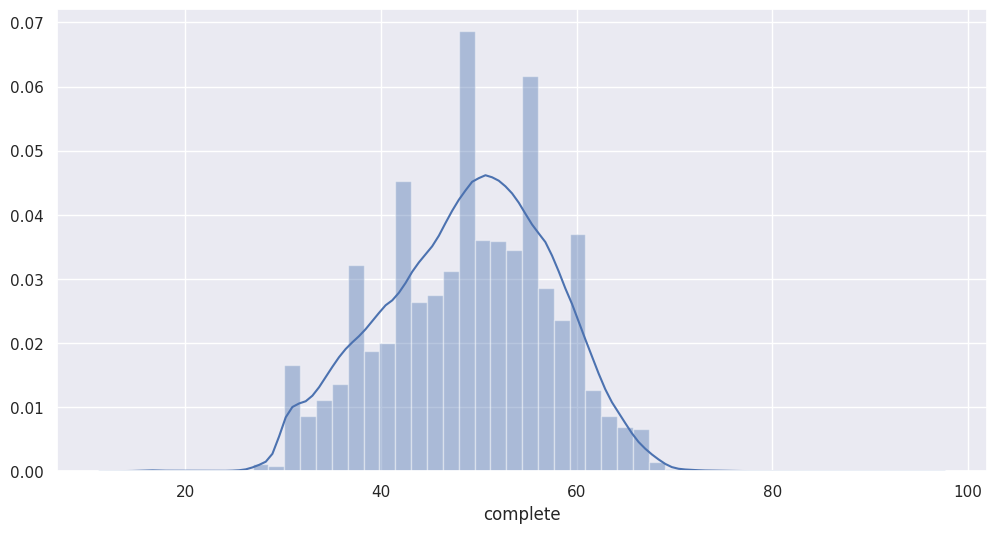

In [48]:
plt.figure(figsize=(12, 6))
sns.distplot(data['complete'])
plt.show()

### Sauvegarde 

In [49]:
print(f"Le fichier contient maintenant {data.shape[0]} lignes et {data.shape[1]} colonnes")

Le fichier contient maintenant 102034 lignes et 141 colonnes


In [50]:
data.to_pickle("../data/interim/products_interimV2.pickle")